# Rakuten USA - Data Engineering Test

### Goal
The goal of this test is not ment to be exhaustive, but we do want to test your skills in analytical thinking, SQL, data wrangling, data analysis, and data visualization. 

**Please remember:** The better that you do on this assignment, the less questions we will have during your on-site interviews. :)

### Expectations
You can expect this test to use the following technologies:
- Python3
- Jupyter Notebook
- PySpark
- PySpark SQL

This test will cover the following areas: 
- Data Cleaning/Wrangling
- Exploratory Data Analysis (EDA)
- Data Visualization

This test should take you no more than 2-4 hours.

### What to turn in, and where to send your test
Please email stirling.waite@rakuten with your finished notebook
- rakuten_engineer_test.ipynb
 
### Questions?
Feel free to email me or call me with any questions about this test
- Email: stirling.waite@rakuten.com
- Phone: 801-856-1426
- LinkedIn Chat: https://www.linkedin.com/in/stirlingwaite/
- Gchat: stirlingw@gmail.com

# About The Dataset

Below you will find a modified free Kaggle competition dataset from https://www.kaggle.com/mayank811/employee-reviews/data using scraped data from Glassdoor.com.

## Context
- Over 67k employee reviews for Google, Amazon, Facebook, Apple, Microsoft, and Netflix.
- Web scraped from Glassdoor

## Content
This dataset contains employee reviews separated into the following categories:

- **Index:** index
- **Company:** Company name
- **Location:** This dataset is global, as such it may include the country's name in parenthesis [i.e "Toronto, ON(Canada)"]. However, if the location is in the USA then it will only include the city and state[i.e "Los Angeles, CA" ]
- **Date Posted:** in the following format MM DD, YYYY
- **Job-Title:** This string will also include whether the reviewer is a 'Current' or 'Former' Employee at the time of the review
- **Summary:** Short summary of employee review
- **Pros:** Pros
- **Cons:** Cons
- **Overall Rating:** 1-5
- **Work/Life Balance Rating:** 1-5
- **Culture and Values Rating:** 1-5
- **Career Opportunities Rating:** 1-5
- **Comp & Benefits Rating:** 1-5
- **Senior Management Rating:** 1-5
- **Helpful Review Count:** 1-5

**Link to Review:** This will provide you with a direct link to the page that contains the review. However it is likely that this link will be outdated

**NOTE:** 'none' is placed in all cells where no data value was found.



# PySpark Initialization

In [1]:
import re
import findspark
findspark.init()
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql import functions as fn
from pyspark.sql import types as t
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql.functions import lit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conf = SparkConf()\
                .setMaster("local[*]")\
                .setAppName("rakutenHomework")
        
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

## Read Dataset into Spark

In [3]:
reviews_df = spark.read.csv("C:/Users/Namrata/Desktop/Rakuten/employee_reviews_usa.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
print(reviews_df.count())
reviews_df.show(10)

28357
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|_c0|company|         location|        dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|  0| google|Mountain View, CA|  Feb 8, 2015|Current Employee

# Data Cleaning & Removing Un-Needed Columns

No one likes dirty data.  Let's clean up this dataset to make it more usable for our use case.

 
1. Make the date field more data friendly
    - Hint #1: Use the provided `review_date_udf` udf provided (it will make your life more simple) 
2. Using the "location" column 
    - Add new columns for city, state, country columns
        - Hint #1: Concider using `fn.split()` to split `location` for columns `city` `state` 
        - Hint #2: I've narrowed down the country to just US, so please use something like below to create the `country` column
            - ```lit("US").alias("country")```
3. Using the "job-title" column  
    - Add a new boolean column titled "current_employee" that will show:
        - 1,  if reviewer is a current employee
        - 0,  if reviewer is not a current employee
        - Hint:  Use spark function `fn.when()` and `col("job-title").contains("")`
    - Remove "Former Employee - " and "" from the "job-title" column
        - Hint: Use the udf function `reg_job_title_udf`
4. Drop un-needed columns 
    - "_c0", "link", "pros", "cons", "advice-to-mgmt", "summary", "location"

##### Useful UDF functions needed for below

In [4]:
review_date_udf = fn.udf(
    lambda x: datetime.strptime(x, ' %b %d, %Y'), DateType()
)

In [5]:
reviews_df_new=reviews_df.withColumn('dates',review_date_udf(col('dates')))

In [6]:
reviews_df_new.show(2)

+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|_c0|company|         location|     dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|
+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|  0| google|Mountain View, CA|2015-02-08|Current Employee ...|The best plac

In [7]:
reviews_df1 = reviews_df_new.withColumn('city', split(reviews_df_new.location, ',')[0])


In [8]:
reviews_df2 = reviews_df1.withColumn('state', split(reviews_df1.location, ',')[1])

In [9]:
reviews_df2.show(10)

+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+-------------+-----+
|_c0|company|         location|     dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|         city|state|
+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+-------------+-----+
|  0| google|Mou

In [10]:
reviews_df3 = reviews_df2.withColumn("country", lit('US'))

In [11]:
reviews_df3.show(2)

+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+-------------+-----+-------+
|_c0|company|         location|     dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|         city|state|country|
+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+-------------+-----+-

In [12]:
reviews_df4 = reviews_df3.withColumn('is_current_employee', (fn.when(col('job_title').like('Current Employee%') ,1).otherwise(0)))

In [13]:
reviews_df4.show(2)

+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+-------------+-----+-------+-------------------+
|_c0|company|         location|     dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|         city|state|country|is_current_employee|
+---+-------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--

In [14]:
def reg_job_title(column):
    res_split=[]
    reg_patterns=["Former Employee - / ", "Current Employee - / "]
    for i in range(len(reg_patterns)):
        res_split=re.findall(r"[^/]+",reg_patterns[i])
        for x in res_split[0].split("|"):
            column = column.replace(x,res_split[1])
    return column[1:]

reg_job_title_udf = fn.udf(reg_job_title, t.StringType())

In [15]:
reviews_df5=reviews_df4.withColumn('job_title',reg_job_title_udf(col('job_title')))

In [16]:
reviews_df5.show(2)

+---+-------+-----------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+-------------+-----+-------+-------------------+
|_c0|company|         location|     dates|         job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|         city|state|country|is_current_employee|
+---+-------+-----------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------

In [17]:
reviews_df6=reviews_df5.drop('_c0','location','pros','cons','advice_to_mgmt','summary','link')

In [18]:
reviews_df6.show(2)

+-------+----------+------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------+-----+-------+-------------------+
|company|     dates|         job_title|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|         city|state|country|is_current_employee|
+-------+----------+------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------+-----+-------+-------------------+
| google|2015-02-08|Anonymous Employee|            5.0|               2.0|                 5.0|                       5.0|               4.0|                   5.0|          498|Mountain View|   CA|     US|                  1|
| google|2018-12-09|              SDE2|            5.0|               4.0|                 4

In [19]:
reviews_df6.printSchema()

root
 |-- company: string (nullable = true)
 |-- dates: date (nullable = true)
 |-- job_title: string (nullable = true)
 |-- overall_ratings: string (nullable = true)
 |-- work_balance_stars: string (nullable = true)
 |-- culture_values_stars: string (nullable = true)
 |-- carrer_opportunities_stars: string (nullable = true)
 |-- comp_benefit_stars: string (nullable = true)
 |-- senior_mangemnet_stars: string (nullable = true)
 |-- helpful_count: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = false)
 |-- is_current_employee: integer (nullable = false)



# Cleaned Spark Dataframe

- I've included the starting of dataframe, but in the `select` you will want to add the fixes and columns needed to answer the questions below


In [20]:
cleaned_reviews_df = reviews_df6.where((col("dates") != 'None') & (col("dates") != ' Jan 0, 0000') & (col("dates") != ' Nov 0, 0000') & (~col("location").contains("(")) & (col("location") != "none")) \
                         .select(
                            col("company"),
                            col("dates"),
                            col("job_title"),
                            col("overall_ratings"),
                            col("work_balance_stars"),
                            col("culture_values_stars"),
                            col("carrer_opportunities_stars"),
                            col("comp_benefit_stars"),
                            col("senior_mangemnet_stars"),
                            col("helpful_count"),
                            col("city"),
                            col("state"),
                            col("country"),
                            col("is_current_employee")
                         )

cleaned_reviews_df.show()

+-------+----------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------+-----+-------+-------------------+
|company|     dates|           job_title|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|         city|state|country|is_current_employee|
+-------+----------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------+-----+-------+-------------------+
| google|2015-02-08|  Anonymous Employee|            5.0|               2.0|                 5.0|                       5.0|               4.0|                   5.0|          498|Mountain View|   CA|     US|                  1|
| google|2018-12-09|                SDE2|            5.0|               4.0|        

# Data Questions

Each question below will have two parts.   Please solve each problem in PySpark and PySpark SQL.  This is to test your ability to solve the problem in PySpark, and to test your ability to solve the problem in SQL.

- PySpark API (https://spark.apache.org/docs/latest/api/python/index.html)
- PySpark SQL API (https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)

In [21]:
cleaned_reviews_df.createOrReplaceTempView("reviews")

### (1) What is the total number of reviews in the data set?

##### PySpark Implmentation

In [22]:
cleaned_reviews_df.count()

27779

##### Spark SQL Implmentation

In [23]:
spark.sql("SELECT count(*) as review_count from reviews").show()

+------------+
|review_count|
+------------+
|       27779|
+------------+



###  (2) How many reviews exist in the dataset per each company?

##### PySpark Implmentation

In [24]:
cleaned_reviews_df.groupBy('company').count().show()

+---------+-----+
|  company|count|
+---------+-----+
|microsoft| 7919|
|   amazon| 9993|
|  netflix|  444|
|    apple| 5729|
| facebook| 1148|
|   google| 2546|
+---------+-----+



##### Spark SQL Implmentation

In [25]:
spark.sql("SELECT company,count(*) as review_count from reviews group by company").show()

+---------+------------+
|  company|review_count|
+---------+------------+
|microsoft|        7919|
|   amazon|        9993|
|  netflix|         444|
|    apple|        5729|
| facebook|        1148|
|   google|        2546|
+---------+------------+



###  (3) How many reviews are from former and current employees per each company?

##### PySpark Implmentation

In [26]:
cleaned_reviews_df.groupBy('company','is_current_employee').count().sort(asc('company'),desc('is_current_employee')).show()

+---------+-------------------+-----+
|  company|is_current_employee|count|
+---------+-------------------+-----+
|   amazon|                  1| 6651|
|   amazon|                  0| 3342|
|    apple|                  1| 3352|
|    apple|                  0| 2377|
| facebook|                  1|  931|
| facebook|                  0|  217|
|   google|                  1| 1620|
|   google|                  0|  926|
|microsoft|                  1| 5129|
|microsoft|                  0| 2790|
|  netflix|                  1|  230|
|  netflix|                  0|  214|
+---------+-------------------+-----+



##### Spark SQL Implmentation

In [27]:
spark.sql("SELECT company,is_current_employee,count(*) as review_count from reviews group by company,is_current_employee order by 1,2 desc").show()

+---------+-------------------+------------+
|  company|is_current_employee|review_count|
+---------+-------------------+------------+
|   amazon|                  1|        6651|
|   amazon|                  0|        3342|
|    apple|                  1|        3352|
|    apple|                  0|        2377|
| facebook|                  1|         931|
| facebook|                  0|         217|
|   google|                  1|        1620|
|   google|                  0|         926|
|microsoft|                  1|        5129|
|microsoft|                  0|        2790|
|  netflix|                  1|         230|
|  netflix|                  0|         214|
+---------+-------------------+------------+



###  (4) What is the average review scores of each current and former employees for each company?

##### PySpark Implmentation

In [28]:
new_df1=cleaned_reviews_df.groupBy('company','is_current_employee').agg(fn.avg('overall_ratings')).sort(asc('company'),desc('is_current_employee'))
new_df2=new_df1['company','is_current_employee',bround('avg(overall_ratings)',2)]
new_df3=new_df2.withColumnRenamed('bround(avg(overall_ratings), 2)', "avg_rating")
new_df3.show()

+---------+-------------------+----------+
|  company|is_current_employee|avg_rating|
+---------+-------------------+----------+
|   amazon|                  1|      3.71|
|   amazon|                  0|      2.98|
|    apple|                  1|      4.08|
|    apple|                  0|      3.83|
| facebook|                  1|       4.7|
| facebook|                  0|      3.93|
|   google|                  1|      4.43|
|   google|                  0|      4.16|
|microsoft|                  1|      3.86|
|microsoft|                  0|      3.56|
|  netflix|                  1|      3.97|
|  netflix|                  0|      2.94|
+---------+-------------------+----------+



##### Spark SQL Implmentation

In [29]:
spark.sql("SELECT company,is_current_employee,cast(avg(overall_ratings) as decimal(10,2)) as avg_rating from reviews group by company,is_current_employee order by 1,2 desc").show()

+---------+-------------------+----------+
|  company|is_current_employee|avg_rating|
+---------+-------------------+----------+
|   amazon|                  1|      3.71|
|   amazon|                  0|      2.98|
|    apple|                  1|      4.08|
|    apple|                  0|      3.83|
| facebook|                  1|      4.70|
| facebook|                  0|      3.93|
|   google|                  1|      4.43|
|   google|                  0|      4.16|
|microsoft|                  1|      3.86|
|microsoft|                  0|      3.56|
|  netflix|                  1|      3.97|
|  netflix|                  0|      2.94|
+---------+-------------------+----------+



###  (5) Show the count of former Google employee reviews and the average work_balance_score ONLY for locations in Seattle, San Francisco, or Utah
- Please show in one solution  
- Hint:  Since you already broke out the location to city, state, country in the data wrangling phase above you can use the city and state columns in your where statement

##### PySpark Implmentation

In [30]:
df1=cleaned_reviews_df.where((col('company')=='google') & (col('is_current_employee')== 0) & (col("city").isin({'Seattle', 'San Francisco', 'Utah'}))).groupBy('company','is_current_employee').agg(fn.count('is_current_employee'),fn.avg('overall_ratings'))
df2=df1.select(col("count(is_current_employee)").alias('count_of_former_Google_employee'),col('avg(overall_ratings)').alias("avg_work_balance_stars"))
df2.show()

+-------------------------------+----------------------+
|count_of_former_Google_employee|avg_work_balance_stars|
+-------------------------------+----------------------+
|                             90|     4.333333333333333|
+-------------------------------+----------------------+



##### Spark SQL Implmentation

In [31]:
spark.sql("SELECT count(*) as count_of_former_Google_employee,avg(work_balance_stars) as avg_work_balance_stars from reviews where company='google' and is_current_employee=0 and city in ('Seattle', 'San Francisco', 'Utah')").show()

+-------------------------------+----------------------+
|count_of_former_Google_employee|avg_work_balance_stars|
+-------------------------------+----------------------+
|                             90|     4.182352941176471|
+-------------------------------+----------------------+



# Data Visualization
1. Turn your Spark dataframe into a Pandas dataframe
    - https://pandas.pydata.org/
2. Answer the visualization questions with any of the following libraries:
    - Matplotlib (https://matplotlib.org/)
    - Seaborn (https://seaborn.pydata.org/introduction.html)
    - Bookeh (https://bokeh.pydata.org/en/latest/)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [33]:
reviews_pd_df = cleaned_reviews_df.toPandas()
reviews_pd_df.head(10)

,company,dates,job_title,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,city,state,country,is_current_employee
0,google,2015-02-08,Anonymous Employee,5.0,2.0,5.0,5.0,4.0,5.0,498,Mountain View,CA,US,1
1,google,2018-12-09,SDE2,5.0,4.0,4.0,4.0,5.0,4.0,1,Mountain View,CA,US,0
2,google,2018-12-11,Software Engineer,5.0,5.0,4.0,4.0,5.0,4.0,0,New York,NY,US,1
3,google,2018-12-10,Anonymous Employee,5.0,5.0,5.0,5.0,5.0,5.0,0,New York,NY,US,1
4,google,2018-12-08,Anonymous Employee,5.0,4.0,5.0,4.0,4.0,3.0,0,Mountain View,CA,US,1
5,google,2018-12-03,Sales Operations Analyst,5.0,5.0,5.0,5.0,4.0,4.0,1,San Francisco,CA,US,1
6,google,2018-11-26,Designer,5.0,3.0,4.0,3.0,4.0,5.0,2,New York,NY,US,1
7,google,2018-11-29,Staff Accountant,5.0,5.0,5.0,5.0,5.0,5.0,0,Los Angeles,CA,US,1
8,google,2018-11-17,Program Manager I,5.0,5.0,5.0,5.0,5.0,5.0,3,San Francisco,CA,US,1
9,google,2018-12-09,Senior Director,3.0,4.0,5.0,5.0,5.0,5.0,0,Mountain View,CA,US,0


### Plot the distributions of reviews for each company (current and former employees) 
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot
    

In [34]:
plot_df=cleaned_reviews_df.groupBy('company','is_current_employee').count().toPandas()
plot_df.head(10)

,company,is_current_employee,count
0,facebook,0,217
1,microsoft,1,5129
2,apple,1,3352
3,facebook,1,931
4,microsoft,0,2790
5,netflix,1,230
6,google,1,1620
7,amazon,0,3342
8,amazon,1,6651
9,apple,0,2377


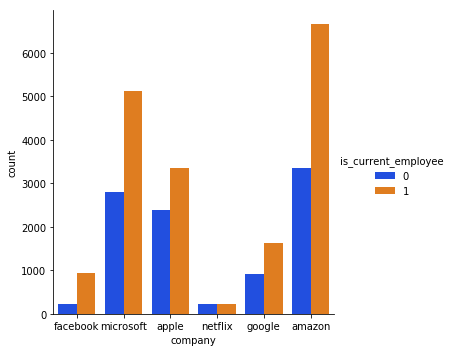

In [35]:
sns.catplot(x="company", y="count",hue="is_current_employee", kind='bar',palette="bright",data=plot_df);

### Plot the distributions of reviews for each company (current and former employees) and their overall ratings
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot

In [36]:
plot_df1=cleaned_reviews_df.groupBy('company','is_current_employee','overall_ratings').count().toPandas()
plot_df1.head(10)

,company,is_current_employee,overall_ratings,count
0,google,1,3.0,128
1,microsoft,0,3.0,778
2,amazon,1,2.0,669
3,microsoft,1,3.0,1077
4,google,0,4.0,297
5,netflix,1,4.0,65
6,apple,1,1.0,70
7,microsoft,1,1.0,122
8,netflix,0,5.0,32
9,netflix,0,1.0,45


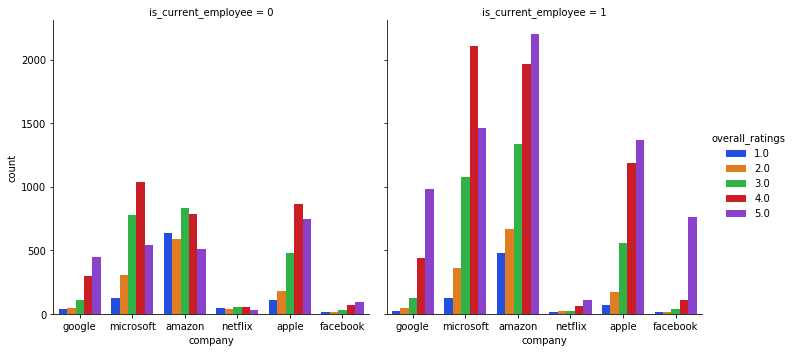

In [37]:
sns.catplot(x="company", y="count", hue="overall_ratings",col="is_current_employee", kind='bar',palette="bright",data=plot_df1);

# Lessons Learned
- Please feel free to let us know anything you want in this section about the test, what you learned, liked, didn't like, etc

Lesson learned:
    The `factorplot` function has been renamed to `catplot`. Received error while using factorplot function. Therefore I
    switched to seaborn.catplot() to plot categorical values.

Likes:
    1.sequence of the steps. 
    2.Different areas covered such as spark installation, integration with jupyter,data cleaning, exploratory analysis, 
      SparkSQL and visualization
    3. Guided analysis of the data
    
Dislike:
    none.